**Work in progress !!**

***Task Completed :***

*   Architecture
*   Train VAE
*   Implement ELBO

***To Do:***


*   Achieve an ELBO of ≥−96
*   Returns:–(logp(x1),...,logp(xM)) estimates of size (M,)




In [0]:
from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import os
import numpy as np
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam

In [0]:
def get_data_loader(dataset_location, batch_size):
    URL = "http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/"
    # start processing
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])
    splitdata = []
    for splitname in ["train", "valid", "test"]:
        filename = "binarized_mnist_%s.amat" % splitname
        filepath = os.path.join(dataset_location, filename)
        utils.download_url(URL + filename, dataset_location, filename = filename, md5=None)
        with open(filepath) as f:
            lines = f.readlines()
        x = lines_to_np_array(lines).astype('float32')
        x = x.reshape(x.shape[0], 1, 28, 28)
        # pytorch data loader
        dataset = data_utils.TensorDataset(torch.from_numpy(x))
        dataset_loader = data_utils.DataLoader(x, batch_size=batch_size, shuffle=splitname == "train")
        splitdata.append(dataset_loader)
    return splitdata

In [0]:
train, valid, test = get_data_loader("binarized_mnist", 64)

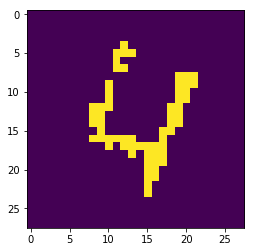

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
for x in train:
    plt.imshow(x[0, 0])
    break

In [0]:
import numpy as np
import random


def distribution3(batch_size=64):
    # 1D gaussian distribution
    while True:
        yield(np.random.normal(0, 1, (batch_size, 200)))


if __name__ == '__main__':
    # Example of usage
    dist = iter(distribution3(64))
    samples = next(dist)

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=256):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
  
    def __init__(self, image_channels=1, h_dim=256, z_dim=100):
        super(VAE, self).__init__()
        
        # Q(z|X) -- encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=3),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 256, kernel_size=5),
            nn.ELU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        # P(X|z) -- decoder
        self.decoder = nn.Sequential(
            
            UnFlatten(),
            nn.ELU(),
            nn.Conv2d(256, 64, kernel_size= 5, padding= 4),
            nn.ELU(),
            nn.Upsample(scale_factor=2, mode = 'bilinear'), #, align_corners=True
            nn.Conv2d(64, 32, kernel_size=3, padding=2),
            nn.ELU(),
            nn.Upsample(scale_factor=2, mode = 'bilinear'), #, align_corners=True
            nn.Conv2d(32, 16, kernel_size=3, padding = 2),
            nn.ELU(),
            nn.Conv2d(16, image_channels, kernel_size = 3, padding = 2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        #print('esp Sample: '+str(np.shape(esp)))
        z = mu + std * esp
        #print('Z Sample: '+str(np.shape(z)))
        return z
    
    def bottleneck(self, h):
        #print('S0 h: '+str(np.shape(h)))
        
        mu, logvar = self.fc1(h), self.fc2(h)
        #print('S1 mu: '+str(np.shape(mu)))
        #print('S2 logvar: '+str(np.shape(logvar)))
        
        z = self.reparameterize(mu, logvar)
        #print('S3 z: '+str(np.shape(z)))

        # Sample z ~ Q(z|X)
        return z, mu, logvar
        
    def representation(self, x):
        #print('S4 x: '+str(np.shape(x)))
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
        #print('B4_encoder x: '+str(np.shape(x)))
        
        h = self.encoder(x)
        #print('AF_encoder h: '+str(np.shape(h)))
        
        z, mu, logvar = self.bottleneck(h)
        #print('S6 mu: '+str(np.shape(mu)))
        #print('S7 logvar: '+str(np.shape(logvar)))
        #print('S8 z: '+str(np.shape(z)))
        
        z = self.fc3(z)
        #print('S9 z: '+str(np.shape(z)))
        
        decoder = self.decoder(z)

        return decoder, z, h, mu, logvar

        


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=4e-4)

def loss_fn(recon_x, x, mu, logvar):
    ## E[log P(X|z)]
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [110]:
epochs = 1
bs = 64

for epoch in range(epochs):
    for idx, (images) in enumerate(train):
        recon_images, z, h, mu, logvar = model(images)
        
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Z Sample: '+str(np.shape(z)))
        print('mu Sample: '+str(np.shape(mu)))
        print('logvar Sample: '+str(np.shape(logvar)))   
    
    to_print = "Epoch[{}/{}] Loss: {:.3f} ,BCE: {:.3f} ,KLD: {:.3f}".format(epoch+1, 
                            epochs, loss/bs, bce/bs, kld/bs)
    print(to_print)




Z Sample: torch.Size([64, 256])
mu Sample: torch.Size([64, 100])
logvar Sample: torch.Size([64, 100])
Z Sample: torch.Size([64, 256])
mu Sample: torch.Size([64, 100])
logvar Sample: torch.Size([64, 100])
Z Sample: torch.Size([64, 256])
mu Sample: torch.Size([64, 100])
logvar Sample: torch.Size([64, 100])
Z Sample: torch.Size([64, 256])
mu Sample: torch.Size([64, 100])
logvar Sample: torch.Size([64, 100])
Z Sample: torch.Size([64, 256])
mu Sample: torch.Size([64, 100])
logvar Sample: torch.Size([64, 100])
Z Sample: torch.Size([64, 256])
mu Sample: torch.Size([64, 100])
logvar Sample: torch.Size([64, 100])
Z Sample: torch.Size([64, 256])
mu Sample: torch.Size([64, 100])
logvar Sample: torch.Size([64, 100])
Z Sample: torch.Size([64, 256])
mu Sample: torch.Size([64, 100])
logvar Sample: torch.Size([64, 100])
Z Sample: torch.Size([64, 256])
mu Sample: torch.Size([64, 100])
logvar Sample: torch.Size([64, 100])
Z Sample: torch.Size([64, 256])
mu Sample: torch.Size([64, 100])
logvar Sample: to

In [0]:
torch.save(model.state_dict(), 'model.torch')

In [0]:
# Q(z|X) -- encoder
# P(X|z) -- decoder
#p(z) -- latent


In [93]:
   
VAE.reparameterize(samples, mu, logvar ).shape

torch.Size([16, 100])

In [94]:
mu.shape, logvar.shape, *mu.size()

(torch.Size([16, 100]), torch.Size([16, 100]), 16, 100)

In [48]:
samples.shape

(64, 200)

In [60]:
samples = 1
VAE.reparameterize(samples, mu, logvar )

tensor([[ 3.3623, -2.7804,  0.0306,  ...,  4.7335,  9.9282,  6.1377],
        [ 1.6541,  6.9573,  8.7320,  ..., -4.6363, -1.7757, -3.1410],
        [ 5.5164, -3.8020, 11.5449,  ...,  3.6949,  4.8117, 10.9112],
        ...,
        [ 2.0829, -8.8239,  1.7025,  ...,  4.9609,  8.4749, -3.5718],
        [ 6.9039, -1.2812,  7.2364,  ..., -4.8858, -2.0875,  5.6604],
        [ 2.1423,  0.7044,  5.5812,  ..., -8.6444, -1.2360, -4.2754]],
       grad_fn=<AddBackward0>)

In [0]:
for epoch in range(epochs):
    for idx, (images) in enumerate(valid):
      print(images.shape)
        #recon_images, z, h, mu, logvar = model(images)
        

In [0]:
from keras.layers import Input, Dense, Lambda

m= 64
k = 200
l = 100

def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, k, l), mean=0., std=1.)
    return mu + K.exp(log_sigma / 2) * eps


# Sample z ~ Q(z|X)
z = Lambda(sample_z)([mu, logvar])